In [1]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USERNAME']
dj.config['database.password'] = os.environ['DJ_PASSWORD']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 200
        
name = 'mvi'
os.environ["DJ_SCHEMA_NAME"] = f"metrics_{name}"
dj.config["nnfabrik.schema_name"] = os.environ["DJ_SCHEMA_NAME"]

In [2]:
import re
import torch
import numpy as np
import pickle 
import json
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'w'
mpl.rcParams["axes.facecolor"] = 'w'
mpl.rcParams["savefig.facecolor"] = 'w'
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["figure.figsize"] = (3, 3)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

from nnsysident.training.trainers import standard_trainer
from nnsysident.models.models import stacked2d_poisson, stacked2d_zig, stacked2d_zil, stacked2d_gamma
from nnsysident.models.ensemble_models import Ensemble
from nnsysident.utility.data_helpers import extract_data_key
from nnsysident.datasets.mouse_loaders import static_loaders

from neuralpredictors.measures.zero_inflated_losses import ZIGLoss, ZILLoss
from neuralpredictors.measures import corr

from dataport.bcm.static import PreprocessedMouseData

random_seed = 27121992
device = 'cuda'

/usr/local/lib/python3.9/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Connecting konstantin@134.76.19.44:3306


---

In [3]:
# Load model architecture configurations
with open('group233_model_configs.pkl', 'rb') as handle:
    zhiwei_configs = pickle.load(handle)
    
modulator_kwargs = zhiwei_configs["mod_key"]
shifter_kwargs = zhiwei_configs["shift_key"]
modulator_kwargs["bias"] = False
shifter_kwargs["bias"] = False

In [4]:
datasets =  [{'animal_id': 26614,
              'session': 1,
              'scan_idx': 16,
              'scan_purpose': 'imagenet'},
             {'animal_id': 26614,
              'session': 2,
              'scan_idx': 17,
              'scan_purpose': 'dei_control_pair'},
             {'animal_id': 26726,
              'session': 6,
              'scan_idx': 11,
              'scan_purpose': 'imagenet'},
             {'animal_id': 26726,
              'session': 7,
              'scan_idx': 13,
              'scan_purpose': 'dei_control_pair'},
             {'animal_id': 26942,
              'session': 1,
              'scan_idx': 11,
              'scan_purpose': 'imagenet'},
             {'animal_id': 26942,
              'session': 2,
              'scan_idx': 8,
              'scan_purpose': 'dei_control_pair'},
             {'animal_id': 27468,
              'session': 3,
              'scan_idx': 12,
              'scan_purpose': 'imagenet'},
             {'animal_id': 27468,
              'session': 4,
              'scan_idx': 7,
              'scan_purpose': 'dei_control_pair'}]

## Imagenet Data

In [5]:
dei_uids = [4981, 1401,  582, 7161,  864, 4952, 2993, 1388, 3457,  207,  213,
       5282, 4440,  323, 6559,  505,  233, 6617, 6177, 5360, 4653, 1301,
       4685, 2746, 3607,  710, 2111, 1053, 5317, 1668, 6758,  578, 5591,
       2866, 7472,  581, 6546, 3062,  103, 2983, 2973, 1956, 3323, 4785,
       6410, 3700, 2460, 4077, 6578, 4131, 1380, 2487,  688, 4775, 6124,
        462,  758, 4171,  682, 2432, 1152,  860,   25,  285, 1490, 6395,
       4267, 5330, 1483, 2128, 2550, 1870,  586,  364,  236, 1709, 1793,
       5116,  125,  826]

In [6]:
src_uids = [4405, 2211,  210, 5292, 6362, 7728, 4242, 2834, 4348,  178,  555,
       5315, 5790,  311, 4934, 1554,  200, 5066, 7605, 7154, 6065, 6831,
       5649, 5986, 2981,  186, 3668, 3425, 4781, 2102, 4768,  566, 5046,
       6902, 5311,  299, 7619, 6267, 1673, 6160, 4669, 3752, 2635, 7283,
       5322, 2388, 2525, 4220, 5132, 7720,   24, 2549, 1599, 7608, 7179,
       1182, 1356, 5978, 1251, 4055, 6816, 6359,   22, 1056, 6994, 5869,
       6182, 4794, 2201, 2023, 2967, 1921, 2354,  561,  704,  174, 3853,
       6010,  663, 3211]

In [8]:
imagenet_key = datasets[0]
assert imagenet_key["scan_purpose"] == "imagenet"
paths = ["./data/static{}-{}-{}-GrayImageNet-7bed7f7379d99271be5d144e5e59a8e7.zip".format(imagenet_key["animal_id"], imagenet_key["session"], imagenet_key["scan_idx"])]
img_data_key = extract_data_key(paths[0])

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': random_seed,
                  'loader_outputs': ["images", "responses", "pupil_center", "behavior"],
                  # 'loader_outputs': ["images", "responses"],
                  'normalize': True,
                  'exclude': ["images"],
                  'subtract_behavior_mean': True,
                  'neuron_ids': [src_uids],
                  }
    
img_dataloaders = static_loaders(**dataset_config)
img_dataset = img_dataloaders["test"][img_data_key].dataset

In [9]:
idx = np.array([(dat["animal_id"] == imagenet_key["animal_id"]) & (dat["session"] != imagenet_key["session"]) & (dat["scan_idx"] != imagenet_key["scan_idx"]) for dat in datasets])
dei_key = np.array(datasets)[idx].item()

assert dei_key["scan_purpose"] == "dei_control_pair"
paths = ["./data/static{}-{}-{}-GrayImageNetDEIInfo-7bed7f7379d99271be5d144e5e59a8e7.zip".format(dei_key["animal_id"], dei_key["session"], dei_key["scan_idx"])]
dei_data_key = extract_data_key(paths[0])

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': random_seed,
                  'loader_outputs': ["images", "responses", "pupil_center", "behavior"],
                  'normalize': True,
                  'exclude': ["images"],
                  'subtract_behavior_mean': True,
                  'neuron_ids': [dei_uids],}

dei_dataloaders_training = static_loaders(**dataset_config)

dei_dataset_training = dei_dataloaders_training["test"][dei_data_key].dataset

---

## Models

### ZIG

In [6]:
# for random_seed in np.arange(5):
#     loc = np.exp(-10)

#     zig_model_config = {
#         "layers": 4,
#         "hidden_channels": 64,
#         "feature_reg_weight": 0.78,
#         "init_mu_range": 0.55,
#         "init_sigma": 0.4,
#         "readout_type": "MultipleGeneralizedFullGaussian2d",
#         'grid_mean_predictor': {'type': 'cortex',
#                                   'input_dimensions': 2,
#                                   'hidden_layers': 0,
#                                   'hidden_features': 0,
#                                   'final_tanh': False},
#         'zero_thresholds': {img_data_key: loc},

#         "input_kern": 15,
#         "gamma_input": 1,
#         "hidden_kern": 13,
#         "depth_separable": True,
#         "k_image_dependent": True,
#         "modulator_kwargs": modulator_kwargs,
#         "shifter_kwargs": shifter_kwargs,
#     }


#     zig_model = stacked2d_zig(img_dataloaders, random_seed, **zig_model_config)
#     zig_model.to(device);

#     score, output, state_dict = standard_trainer(zig_model,
#                                                img_dataloaders,
#                                                random_seed, 
#                                                loss_function="ZIGLoss", 
#                                                stop_function="get_loss", 
#                                                track_training=False, 
#                                                maximize=False)
#     zig_model.eval();
#     torch.save(state_dict, "ZIG_statedict" + img_data_key + f"-seed{random_seed}" + ".inshallah")

In [ ]:
# loc = np.exp(-10)

# zig_model_config = {
#     "layers": 4,
#     "hidden_channels": 64,
#     "feature_reg_weight": 0.78,
#     "init_mu_range": 0.55,
#     "init_sigma": 0.4,
#     "readout_type": "MultipleGeneralizedFullGaussian2d",
#     'grid_mean_predictor': {'type': 'cortex',
#                               'input_dimensions': 2,
#                               'hidden_layers': 0,
#                               'hidden_features': 0,
#                               'final_tanh': False},
#     'zero_thresholds': loc,

#     "input_kern": 15,
#     "gamma_input": 1,
#     "hidden_kern": 13,
#     "depth_separable": True,
#     "k_image_dependent": True,
#     "modulator_kwargs": modulator_kwargs,
#     "shifter_kwargs": shifter_kwargs,
# }


# zig_model = stacked2d_zig(img_dataloaders, random_seed, **zig_model_config)
# zig_model.to(device);

In [12]:
zig_model_config = {'zero_thresholds': 4.5399929762484854e-05,
 'hidden_kern': 13,
 'input_kern': 15,
 'init_sigma': 0.4,
 'init_mu_range': 0.55,
 'gamma_input': 1.0,
 'grid_mean_predictor': {'type': 'cortex',
  'input_dimensions': 2,
  'hidden_layers': 0,
  'hidden_features': 0,
  'final_tanh': False},
 'feature_reg_weight': 0.78,
 'readout_type': 'MultipleGeneralizedFullGaussian2d',
 'modulator_kwargs': {'mod_type': 'MLP',
  'layers': 2,
  'hidden_channels': 10,
  'gamma_modulator': 0.0,
  'bias': False},
 'shifter_kwargs': {'shift_type': 'MLP',
  'shift_layers': 3,
  'hidden_channels_shifter': 5,
  'gamma_shifter': 0.0,
  'bias': False},
 'batch_norm_scale': False,
 'independent_bn_bias': True,
 'init_with_lurz_core': True}


zig_model = stacked2d_zig(img_dataloaders, random_seed, **zig_model_config)
zig_model.to(device);

/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/cores/conv2d.py:125: UserWarning: The default of `independent_bn_bias=True` will ignore the kwargs `bias`, `batch_norm_scale`, and `final_batchnorm_scale` when initializing the batchnorm. If you want to use these arguments, please set `independent_bn_bias=False`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:63: UserWarning: Ignoring input {'mod_type': 'MLP'} when creating MLPModulator
  warnings.warn("Ignoring input {} when creating {}".format(repr(kwargs), self.__class__.__name__))


In [ ]:
score, output, state_dict = standard_trainer(zig_model,
                                           img_dataloaders,
                                           random_seed, 
                                           loss_function="ZIGLoss", 
                                           stop_function="get_loss", 
                                           track_training=True, 
                                           maximize=False,)
zig_model.eval();
# torch.save(state_dict, "ZIG_statedict" + img_data_key + ".inshallah")


# zig_model.load_state_dict(torch.load("ZIG_statedict" + img_data_key + ".inshallah"))
# zig_model.eval();

val_correlation: 0.29963976

zig_val_loss: -16377972.0

zig_train_loss: -150074690.0

### Gamma

In [ ]:
gamma_model_config = {
    "layers": 4,
    "hidden_channels": 64,
    "feature_reg_weight": 0.78,
    "init_mu_range": 0.55,
    "init_sigma": 0.4,
    "readout_type": "MultipleGeneralizedFullGaussian2d",
    'grid_mean_predictor': {'type': 'cortex',
                              'input_dimensions': 2,
                              'hidden_layers': 0,
                              'hidden_features': 0,
                              'final_tanh': False},

    "input_kern": 15,
    "gamma_input": 1,
    "hidden_kern": 13,
    "depth_separable": True,
    "k_image_dependent": True,
    "modulator_kwargs": modulator_kwargs,
    "shifter_kwargs": shifter_kwargs,
}

gamma_model = stacked2d_gamma(img_dataloaders, random_seed, **gamma_model_config)
gamma_model.to(device);

In [ ]:
score, output, state_dict = standard_trainer(gamma_model,
                                           img_dataloaders,
                                           random_seed, 
                                           loss_function=gamma_model.loss_fn, 
                                           stop_function="get_loss", 
                                           track_training=True, 
                                           maximize=False,)
gamma_model.eval();

### Poisson

In [ ]:
# for random_seed in np.arange(5):

#     poisson_model_config = {
#         "layers": 4,
#         "hidden_channels": 64,
#         "gamma_readout": 0.78,
#         "init_mu_range": 0.55,
#         "init_sigma": 0.4,
#         "readout_type": "MultipleGeneralizedFullGaussian2d",
#         'grid_mean_predictor': {'type': 'cortex',
#                                   'input_dimensions': 2,
#                                   'hidden_layers': 0,
#                                   'hidden_features': 0,
#                                   'final_tanh': False},
#         "input_kern": 15,
#         "gamma_input": 1,
#         "hidden_kern": 13,
#         "depth_separable": True,
#         "modulator_kwargs": modulator_kwargs,
#         "shifter_kwargs": shifter_kwargs,  
#     }


#     poisson_model = stacked2d_poisson(img_dataloaders, random_seed, **poisson_model_config)
#     poisson_model.to(device);

#     score, output, state_dict = standard_trainer(poisson_model,
#                                                  img_dataloaders,
#                                                  random_seed,
#                                                  loss_function="PoissonLoss",
#                                                  track_training=False, )
#     poisson_model.eval();
#     torch.save(state_dict, "Poisson_statedict" + img_data_key + f"-seed{random_seed} + ".inshallah"")

In [ ]:
poisson_model_config = {
    "layers": 4,
    "hidden_channels": 64,
    "gamma_readout": 0.78,
    "init_mu_range": 0.55,
    "init_sigma": 0.4,
    "readout_type": "MultipleGeneralizedFullGaussian2d",
    'grid_mean_predictor': {'type': 'cortex',
                              'input_dimensions': 2,
                              'hidden_layers': 0,
                              'hidden_features': 0,
                              'final_tanh': False},
    "input_kern": 15,
    "gamma_input": 1,
    "hidden_kern": 13,
    "depth_separable": True,
    "modulator_kwargs": modulator_kwargs,
    "shifter_kwargs": shifter_kwargs,  
}

poisson_model = stacked2d_poisson(img_dataloaders, random_seed, **poisson_model_config)
poisson_model.to(device);

In [ ]:
score, output, state_dict = standard_trainer(poisson_model,
                                             img_dataloaders,
                                             random_seed,
                                             loss_function="PoissonLoss",
                                             track_training=True, )
poisson_model.eval();
# torch.save(state_dict, "Poisson_statedict" + img_data_key + ".inshallah")


# poisson_model.load_state_dict(torch.load("Poisson_statedict" + img_data_key + ".inshallah"))
# poisson_model.eval();

In [ ]:
score

val_correlation 0.32643822

val_loss 2107371.0

train_loss 17724226.0

---

# Compare DEIs/MEIs

### DEI data

In [24]:
imagenet_key = datasets[0]

In [25]:
idx = np.array([(dat["animal_id"] == imagenet_key["animal_id"]) & (dat["session"] != imagenet_key["session"]) & (dat["scan_idx"] != imagenet_key["scan_idx"]) for dat in datasets])
dei_key = np.array(datasets)[idx].item()

assert dei_key["scan_purpose"] == "dei_control_pair"
paths = ["./data/static{}-{}-{}-GrayImageNetDEIInfo-7bed7f7379d99271be5d144e5e59a8e7.zip".format(dei_key["animal_id"], dei_key["session"], dei_key["scan_idx"])]
dei_data_key = extract_data_key(paths[0])

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': random_seed,
                  'return_test_sampler': True,
                  'tier': "test",
                  'loader_outputs': ["images", 'responses', 'trial_idx', "dei_unit_ids", "dei_src_unit_ids", "dei_mean_distances",  "pupil_center", "behavior"],
                  'normalize': True,
                  'exclude': ["images", "trial_idx", "dei_unit_ids", "dei_src_unit_ids", "dei_mean_distances"],
                  'subtract_behavior_mean': True,
                  'neuron_ids': [dei_uids]}

dei_dataloaders = static_loaders(**dataset_config)

dei_dataset = dei_dataloaders["test"][dei_data_key].dataset

Returning only test sampler with repeats...


In [11]:
images, responses, trial_idxs, dei_unit_ids, dei_src_unit_ids, dei_mean_distances = [], [], [], [], [], []
for image, response, trial_idx, dei_unit_id, dei_src_unit_id, dei_mean_distance, pupil_center, behavior in dei_dataloaders["test"][dei_data_key]:
    if (len(response) == 20) & (torch.unique(dei_mean_distance <= 10)):
        images.append(image)
        responses.append(response)
        trial_idxs.append(trial_idx)
        dei_unit_ids.append(dei_unit_id)
        dei_src_unit_ids.append(dei_src_unit_id)
        dei_mean_distances.append(dei_mean_distance)
images = torch.stack(images)
responses = torch.stack(responses)
trial_idxs = torch.stack(trial_idxs).cpu().data.numpy()
dei_unit_ids = torch.stack(dei_unit_ids).cpu().data.numpy()
dei_src_unit_ids = torch.stack(dei_src_unit_ids).cpu().data.numpy()
dei_mean_distances = torch.stack(dei_mean_distances).cpu().data.numpy()

### Diff of DEIs

In [21]:
my_unit_ids = []
imgs = np.full((3, len(possible_src_unit_ids), 1, 36, 64), np.nan)
for i, possible_src_unit_id in enumerate(possible_src_unit_ids):
    image_idx = np.unique(np.where(dei_src_unit_ids == possible_src_unit_id)[0])
    my_unit_ids.append(int(possible_src_unit_id))


    img = torch.unique(images[image_idx], dim=1).squeeze(1)
    mei_dei_idx = [0, 1, 2]
    if len(image_idx) != 3:
        idx = np.where(np.isin(dei_dataset.trial_info.trial_idx, trial_idxs[image_idx]))[0]
        if 'mask_fixed_mei' in np.unique(dei_dataset.trial_info.frame_image_class[idx]):
            mei_dei_idx = [0, 1] if len(image_idx) == 2 else [0]
        else:
            mei_dei_idx = [1, 2] if len(image_idx) == 2 else [1]
    imgs[mei_dei_idx, i, :, :, :] = img.cpu().data

In [22]:
my_unit_ids[:9]

[1056, 3853, 1673, 2102, 6831, 4794, 6816, 6362, 5132]

Text(0.5, 1.0, 'DIFF(DEIs)')

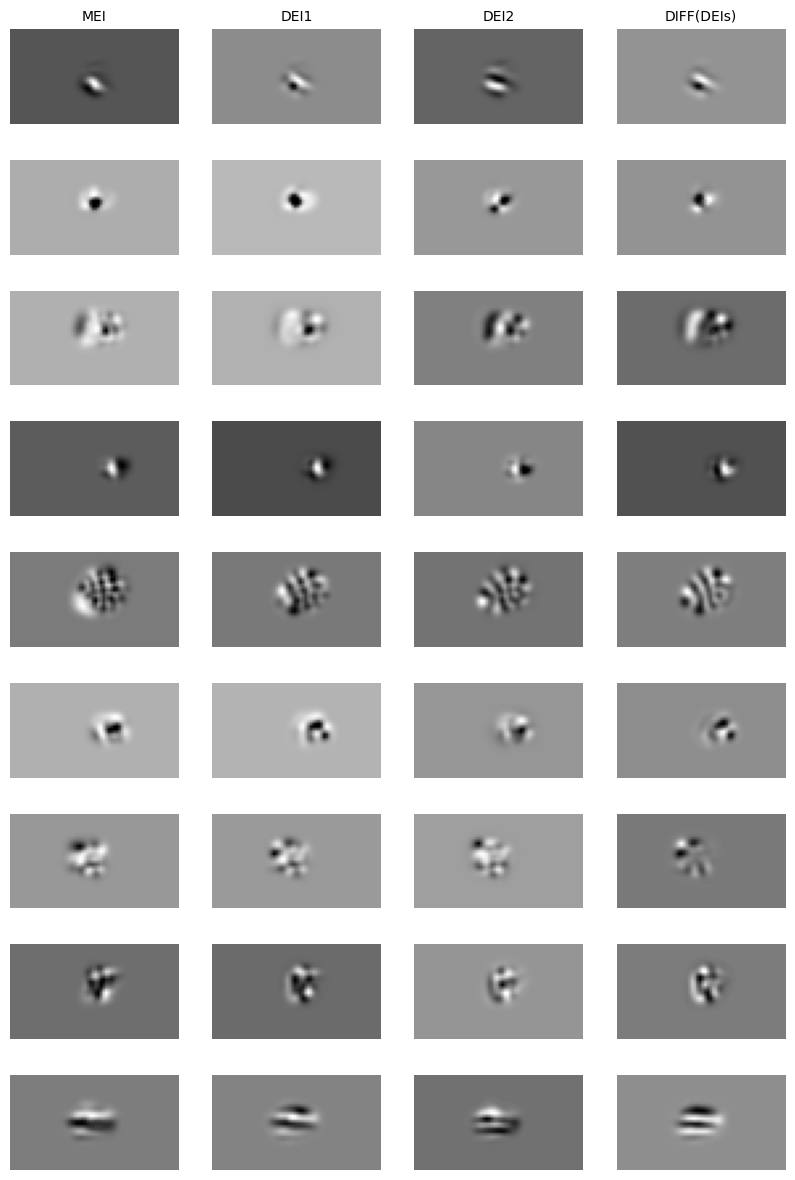

In [12]:
fig, axes = plt.subplots(9, 4, figsize=(10, 15), dpi=100)
fontsize = 10

for i in range(9):
    axes[i, 0].imshow(imgs[0, i, 0, :, :], cmap="gray")
    axes[i, 1].imshow(imgs[1, i, 0, :, :], cmap="gray")
    axes[i, 2].imshow(imgs[2, i, 0, :, :], cmap="gray")
    axes[i, 3].imshow(imgs[1, i, 0, :, :] - imgs[2, i, 0, :, :], cmap="gray")
for ax in axes.flatten():
    ax.axis("off")
axes[0, 0].set_title("MEI", fontsize=fontsize)
axes[0, 1].set_title("DEI1", fontsize=fontsize)
axes[0, 2].set_title("DEI2", fontsize=fontsize)
axes[0, 3].set_title("DIFF(DEIs)", fontsize=fontsize)
# fig.savefig("diff_of_deis" + ".png", bbox_inches="tight", transparent=False)

### Get data for following plots

In [14]:
# Get possible unit ids (in the source-dataset frame)
possible_src_unit_ids = np.unique(dei_src_unit_ids, axis=1).squeeze()

# Sort according to mean distances (increasing)
src_sort_idx = np.argsort(np.unique(dei_mean_distances, axis=1).squeeze())
possible_src_unit_ids = possible_src_unit_ids[src_sort_idx]

# Remove duplicates (from several DEIs/MEI)
_, idx = np.unique(possible_src_unit_ids, return_index=True)
possible_src_unit_ids = possible_src_unit_ids[np.sort(idx)]

NameError: name 'dei_src_unit_ids' is not defined

In [ ]:
zig_model = Ensemble(zig_se2d_fullgaussian2d, zig_model_config, img_dataloaders, "ZIG_statedict" + img_data_key, np.arange(5), device=device)
poisson_model = Ensemble(poisson_se2d_fullgaussian2d, poisson_model_config, img_dataloaders, "Poisson_statedict" + img_data_key, np.arange(5), device=device)

# zig_model.shifter = None
# poisson_model.shifter = None
# poisson_model.modulator = None

In [17]:
zig_means = np.full((3, len(possible_src_unit_ids)), np.nan)
zig_variances = np.full((3, len(possible_src_unit_ids)), np.nan)
poisson_means = np.full((3, len(possible_src_unit_ids)), np.nan)
poisson_variances = np.full((3, len(possible_src_unit_ids)), np.nan)
real_resp_means = np.full((3, len(possible_src_unit_ids)), np.nan)
real_resp_vars = np.full((3, len(possible_src_unit_ids)), np.nan)
imgs = np.full((3, len(possible_src_unit_ids), 1, 36, 64), np.nan)
for i, possible_src_unit_id in enumerate(possible_src_unit_ids):
    image_idx = np.unique(np.where(dei_src_unit_ids == possible_src_unit_id)[0])

    dei_neuron_id = np.unique(dei_unit_ids[image_idx]).item()
    src_neuron_id = np.unique(dei_src_unit_ids[image_idx]).item()
    src_neuron_idx = np.where(img_dataset.neurons.unit_ids == src_neuron_id)[0].item()
    dei_neuron_idx = np.where(dei_dataset.neurons.unit_ids == dei_neuron_id)[0].item()

    img = torch.unique(images[image_idx], dim=1).squeeze(1)
    mei_dei_idx = [0, 1, 2]
    if len(image_idx) != 3:
        idx = np.where(np.isin(dei_dataset.trial_info.trial_idx, trial_idxs[image_idx]))[0]
        if 'mask_fixed_mei' in np.unique(dei_dataset.trial_info.frame_image_class[idx]):
            mei_dei_idx = [0, 1] if len(image_idx) == 2 else [0]
        else:
            mei_dei_idx = [1, 2] if len(image_idx) == 2 else [1]
    imgs[mei_dei_idx, i, :, :, :] = img.cpu().data
    
    # TODO: Keep this line?
#     img = torch.stack([((im - im.mean()) / (im.std())) for im in img.squeeze()])[:, None]

    behavior = torch.zeros((img.shape[0], 3)).to(device)
    pupil_center = torch.zeros((img.shape[0], 2)).to(device)
    
    zig_means_ = zig_model.predict_mean(img, data_key=img_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy()
    zig_variances_ = zig_model.predict_variance(img, data_key=img_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy()
    # poisson_means_ = poisson_model.predict_mean(img, data_key=img_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy()
    # poisson_variances_ = poisson_model.predict_variance(img, data_key=img_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy()

    zig_means[mei_dei_idx, i] = zig_means_[:, src_neuron_idx]
    zig_variances[mei_dei_idx, i] = zig_variances_[:, src_neuron_idx]
    # poisson_means[mei_dei_idx, i] = poisson_means_[:, src_neuron_idx]
    # poisson_variances[mei_dei_idx, i] = poisson_variances_[:, src_neuron_idx]
    
    real_resp_means[mei_dei_idx, i] = np.mean(responses[image_idx].cpu().data.numpy(), axis=1)[:, dei_neuron_idx]
    real_resp_vars[mei_dei_idx, i] = np.var(responses[image_idx].cpu().data.numpy(), axis=1)[:, dei_neuron_idx]
keep_idx = ~np.isnan(zig_means).any(axis=0)

### Compare Zhiwei Model with Konstantin model

In [18]:
with open(r"group233_mei_dei_resps.pkl", "rb") as input_file:
    e = pickle.load(input_file).T

In [33]:
y_real.shape

(3, 52)

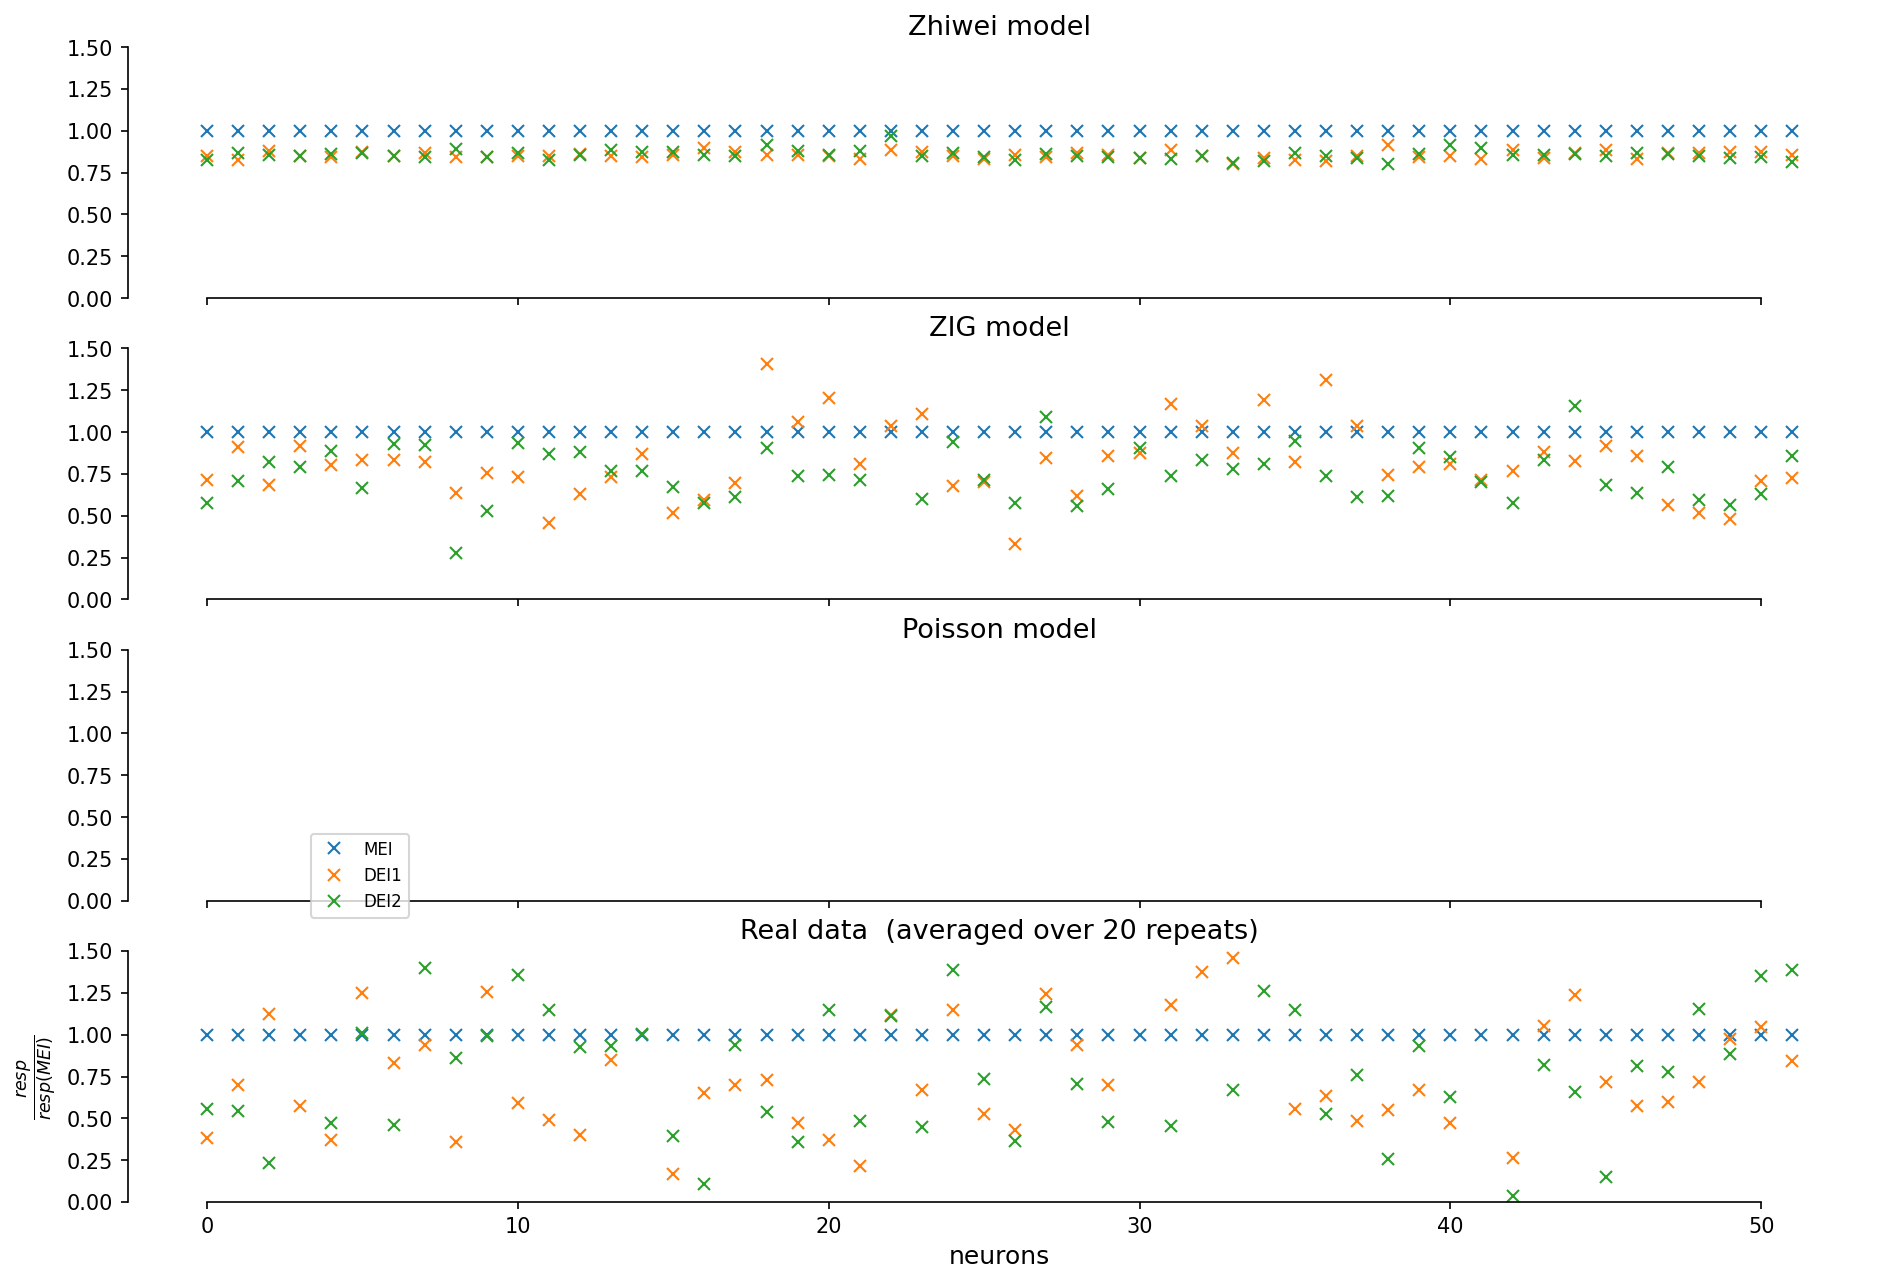

In [19]:
fig, axes = plt.subplots(4, 1, figsize=(15, 10), dpi=150, sharex=True, sharey=True)
fontsize = 10


y_zhiwei = e / e[0, :]
y_zig = zig_means / zig_means[0, :]
y_zig = y_zig[:, keep_idx]
y_poisson = poisson_means / poisson_means[0, :]
y_poisson = y_poisson[:, keep_idx]
y_real = real_resp_means / real_resp_means[0, :]
y_real = y_real[:, keep_idx]
x = np.arange(y_real.shape[1])

# Zhiwei
for i in range(3):
    axes[0].plot(x, y_zhiwei[i,:], ls="", marker="x")

# ZIG
for i in range(3):
    axes[1].plot(x, y_zig[i,:], ls="", marker="x")
    
# Poisson
for i in range(3):
    axes[2].plot(x, y_poisson[i,:], ls="", marker="x")
    axes[2].ticklabel_format(useOffset=False)
    
# Real data
for i, label in enumerate(["MEI", "DEI1", "DEI2"]):
    axes[3].plot(x, y_real[i,:], ls="", marker="x", label=label)
    
    
axes[0].set_title("Zhiwei model", fontsize=fontsize*1.3)
axes[1].set_title("ZIG model", fontsize=fontsize*1.3)
axes[2].set_title("Poisson model", fontsize=fontsize*1.3)
axes[3].set_title("Real data  (averaged over 20 repeats)", fontsize=fontsize*1.3)
axes[3].set_xlabel("neurons", fontsize=fontsize*1.2)
axes[3].set_ylabel(r"$\frac{resp}{resp(MEI)}$", fontsize=fontsize*1.2)

axes[0].set(ylim=[0, 1.5])

# axes[3].legend(bbox_to_anchor=(0.15, 1., 0, 0), frameon=True, fontsize=fontsize*.8)
axes[3].legend(bbox_to_anchor=(0.1, 1.1, 0, 0), frameon=True, fontsize=fontsize*.8)

sns.despine(trim=True)
# fig.savefig("Zhiwei_Model_Comparison" + ".png", bbox_inches="tight", transparent=False)

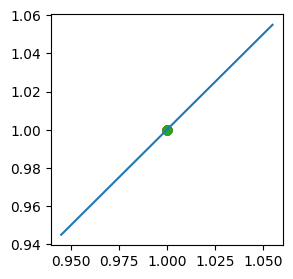

In [20]:
fig, ax = plt.subplots()
ax.scatter(y_zhiwei[0], y_poisson[0])
ax.scatter(y_zhiwei[0], y_zig[0])
ax.scatter(y_zhiwei[0], y_real[0])
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_ylim()[0], ax.get_ylim()[1]])

#### Rank correlation

In [ ]:
zig_zhiwei, poisson_zhiwei, zig_real, poisson_real, zhiwei_real = [], [], [], [], []
for i in range(e.shape[-1]):
    zig_zhiwei_, p = spearmanr(e[:, i], zig_means[:, keep_idx][:, i], axis=0)
    poisson_zhiwei_, p = spearmanr(e[:, i], poisson_means[:, keep_idx][:, i], axis=0)
    zig_real_, p = spearmanr(real_resp_means[:, keep_idx][:, i], zig_means[:, keep_idx][:, i], axis=0)
    poisson_real_, p = spearmanr(real_resp_means[:, keep_idx][:, i], poisson_means[:, keep_idx][:, i], axis=0)
    zhiwei_real_, p = spearmanr(real_resp_means[:, keep_idx][:, i], e[:, i], axis=0)
    
    zig_zhiwei.append(zig_zhiwei_)
    poisson_zhiwei.append(poisson_zhiwei_)
    zig_real.append(zig_real_)
    poisson_real.append(poisson_real_)
    zhiwei_real.append(zhiwei_real_)

print("ZIG     |  Zhiwei: {:.5f}".format(np.mean(zig_zhiwei)))
print("Poisson |  Zhiwei: {:.5f}".format(np.mean(poisson_zhiwei)))
print("ZIG     |  Real:   {:.5f}".format(np.mean(zig_real)))
print("Poisson |  Real:   {:.5f}".format(np.mean(poisson_real)))
print("Zhiwei  |  Real:   {:.5f}".format(np.mean(zhiwei_real)))

#### Full Correlation

In [ ]:
zig_zhiwei = np.mean(corr(e, zig_means[:, keep_idx], axis=0))
poisson_zhiwei = np.mean(corr(e, poisson_means[:, keep_idx], axis=0))
zig_real = np.mean(corr(real_resp_means[:, keep_idx], zig_means[:, keep_idx], axis=0))
poisson_real = np.mean(corr(real_resp_means[:, keep_idx], poisson_means[:, keep_idx], axis=0))
zhiwei_real = np.mean(corr(real_resp_means[:, keep_idx], e, axis=0))

print("ZIG     |  Zhiwei: {:.5f}".format(np.mean(zig_zhiwei)))
print("Poisson |  Zhiwei: {:.5f}".format(np.mean(poisson_zhiwei)))
print("ZIG     |  Real:   {:.5f}".format(np.mean(zig_real)))
print("Poisson |  Real:   {:.5f}".format(np.mean(poisson_real)))
print("Zhiwei  |  Real:   {:.5f}".format(np.mean(zhiwei_real)))

___

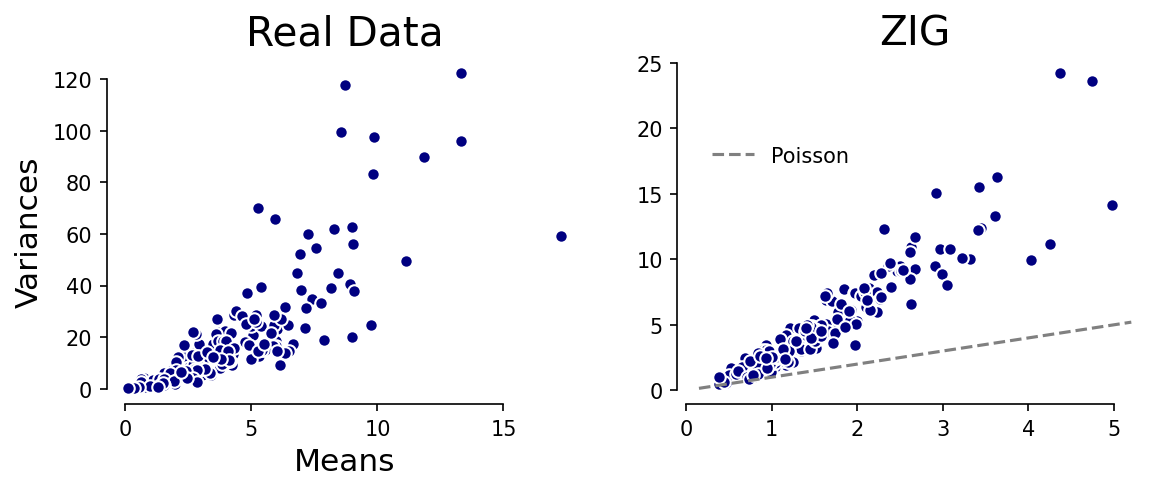

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=150)
color = "navy"
ec="white"
fontsize = 15

axes[0].scatter(real_resp_means.flatten(), real_resp_vars.flatten(), color=color, ec=ec)
axes[0].set_xlabel("Means", fontsize=fontsize)
axes[0].set_ylabel("Variances", fontsize=fontsize)
axes[0].set_title("Real Data", fontsize=fontsize*1.3)

axes[1].scatter(zig_means.flatten(), zig_variances.flatten(), color=color, ec=ec)
axes[1].set_title("ZIG", fontsize=fontsize*1.3)
axes[1].plot([axes[1].get_xlim()[0], axes[1].get_xlim()[1]], [axes[1].get_xlim()[0], axes[1].get_xlim()[1]], ls="--", color="grey", label="Poisson")
# axes[1].set(xlim=[0, 15], ylim=[0, 400])
axes[1].legend(frameon=False, bbox_to_anchor=[.4,.8,0,0])
sns.despine(trim=True)

# fig.savefig("mean_variance_comparison" + ".png", bbox_inches="tight", transparent=False)

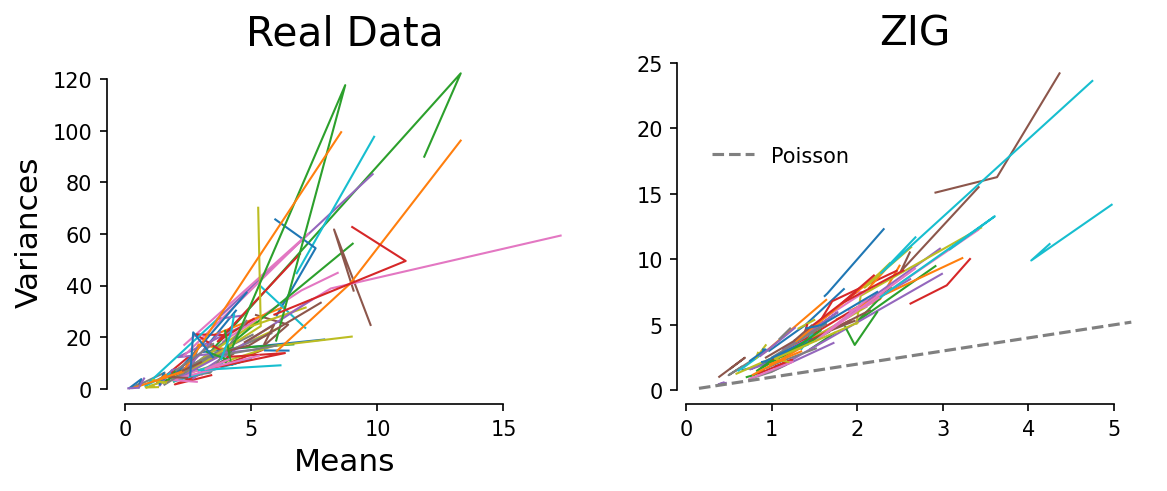

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=150)
color = "navy"
ec="white"
fontsize = 15

axes[0].plot(real_resp_means, real_resp_vars, marker="", lw=1)
axes[0].set_xlabel("Means", fontsize=fontsize)
axes[0].set_ylabel("Variances", fontsize=fontsize)
axes[0].set_title("Real Data", fontsize=fontsize*1.3)

axes[1].plot(zig_means, zig_variances, marker="", lw=1)
axes[1].set_title("ZIG", fontsize=fontsize*1.3)
axes[1].plot([axes[1].get_xlim()[0], axes[1].get_xlim()[1]], [axes[1].get_xlim()[0], axes[1].get_xlim()[1]], ls="--", color="grey", label="Poisson")
# axes[1].set(xlim=[0, 15], ylim=[0, 400])
axes[1].legend(frameon=False, bbox_to_anchor=[.4,.8,0,0])
sns.despine(trim=True)

# fig.savefig("mean_variance_comparison_lines" + ".png", bbox_inches="tight", transparent=False)

___

## Correlation to mean and variance

In [172]:
features_trained = zig_model.readout["26614-1-16-0"].features.data.cpu().numpy()
features_init = zig_model_dei.readout["26614-2-17-0"].features.data.cpu().numpy()

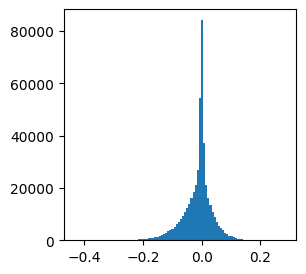

In [176]:
i = 2
plt.hist(features_trained[i].flatten(), bins=100);

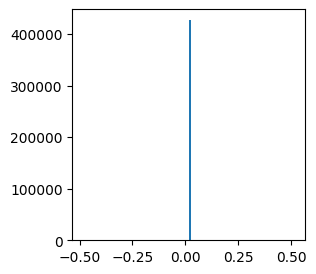

In [177]:
plt.hist(features_init[i].flatten(), bins=100);

In [ ]:
state_dict = zig_model.state_dict()
state_dict = {key.replace("26614-1-16-0", "26614-2-17-0"): value for key, value in state_dict.items()}

zig_model_dei = stacked2d_zig(dei_dataloaders_training, random_seed, **zig_model_config)
zig_model_dei.load_state_dict(state_dict)
zig_model_dei.to(device);

score, output, state_dict = standard_trainer(zig_model_dei,
                                           dei_dataloaders_training,
                                           random_seed, 
                                           loss_function="ZIGLoss", 
                                           stop_function="get_loss", 
                                           track_training=True, 
                                           maximize=False,
                                           detach_core=True)
zig_model_dei.eval();
# torch.save(state_dict, "ZIG_statedict_dei" + img_data_key + ".inshallah")


# zig_model_dei.load_state_dict(torch.load("ZIG_statedict" + img_data_key + ".inshallah"))
# zig_model_dei.eval();

In [ ]:
poisson_model_dei = stacked2d_poisson(dei_dataloaders_training, random_seed, **poisson_model_config)
poisson_model_dei.load_state_dict(poisson_model.state_dict(), strict=False)
poisson_model_dei.to(device);

score, output, state_dict = standard_trainer(poisson_model_dei,
                                             dei_dataloaders_training,
                                             random_seed,
                                             loss_function="PoissonLoss",
                                             track_training=True, 
                                             detach_core=True)
poisson_model_dei.eval();
# torch.save(state_dict, "Poisson_statedict" + img_data_key + ".inshallah")


# poisson_model_dei.load_state_dict(torch.load("Poisson_statedict" + img_data_key + ".inshallah"))
# poisson_model_dei.eval();

In [73]:
zig_means, zig_variances, poisson_means, poisson_variances, real_means, real_variances = [], [] , [], [], [], []
for image, response, trial_idx, dei_unit_id, dei_src_unit_id, dei_mean_distance, pupil_center, behavior in dei_dataloaders["test"][dei_data_key]:
    
    # REMOVE!
    # behavior = torch.zeros((image.shape[0], 3)).to(device)
    # pupil_center = torch.zeros((image.shape[0], 2)).to(device)
    
    zig_means.append(zig_model_dei.predict_mean(image, data_key=dei_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy().mean(0))
    zig_variances.append(zig_model_dei.predict_variance(image, data_key=dei_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy().mean(0))
    
    # poisson_means.append(poisson_model_dei.predict_mean(image, data_key=dei_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy().mean(0))
    # poisson_variances.append(poisson_model_dei.predict_variance(image, data_key=dei_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy().mean(0))
    
    real_means.append(torch.mean(response, axis=0).cpu().data.numpy())
    real_variances.append(torch.var(response, axis=0).cpu().data.numpy())
    
zig_means = np.stack(zig_means)
zig_variances = np.stack(zig_variances)
# poisson_means = np.stack(poisson_means)
# poisson_variances = np.stack(poisson_variances)
real_means = np.stack(real_means)
real_variances = np.stack(real_variances)

In [117]:
# src_uids = []
# for uid in dei_dataloaders["test"][dei_data_key].dataset.trial_info.dei_src_unit_ids:
#     if not np.isnan(uid) and uid not in src_uids:
#         src_uids.append(uid)
        
# dei_uids = []
# for uid in dei_dataloaders["test"][dei_data_key].dataset.trial_info.dei_unit_ids:
#     if not np.isnan(uid) and uid not in dei_uids:
#         dei_uids.append(uid)
        
# src_uids = np.array(src_uids).astype(int)
# dei_uids = np.array(dei_uids).astype(int)

TypeError: list indices must be integers or slices, not tuple

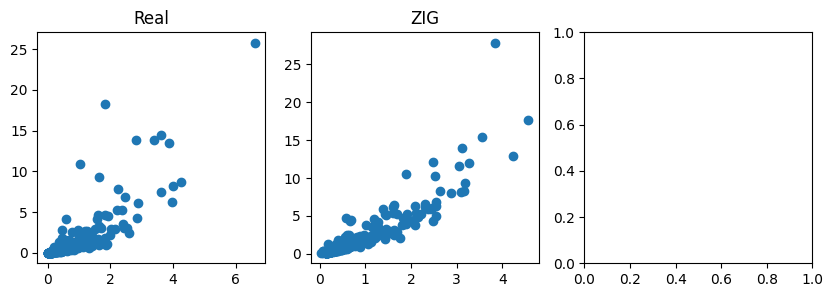

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(real_means[:, 0], real_variances[:, 0])
axes[0].set_title("Real")

axes[1].scatter(zig_means[:, 0], zig_variances[:, 0])
axes[1].set_title("ZIG")

axes[2].scatter(poisson_means[:, 0], poisson_variances[:, 0])
axes[2].set_title("Poisson")

sns.despine(trim=True)

In [140]:
from neuralpredictors.measures import corr

zig_mean_corr = corr(zig_means, real_means, axis=0).mean(0)
zig_var_corr = corr(zig_variances, real_variances, axis=0).mean(0)
poisson_mean_corr = corr(poisson_means, real_means, axis=0).mean(0)
poisson_var_corr = corr(poisson_variances, real_variances, axis=0).mean(0)



print(zig_mean_corr, zig_var_corr)
print(poisson_mean_corr, poisson_var_corr)

0.27001536 0.16237831
0.3396199 0.21391572


___

In [67]:
n = range(len(real_means))
mean_threshold = 1.e-3
signs = []
for m, v in zip(real_means.T, real_variances.T):
    for i in range(len(m)):
        for j in range(len(m)-i-1):
            if abs(m[i] - m[i+j+1]) < mean_threshold:
                signs.append(np.sign(v[i] - v[i+j+1]))
                
        

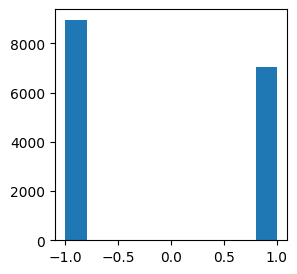

In [69]:
plt.hist(signs);

In [74]:
mean_threshold = 1.e-3
var_threshold = 0.0001

result, signs, model_signs, real_signs = [], [], [], []
for i in range(real_means.shape[1]):
    

    idx = np.argsort(real_means[:, i])
    diffs = np.diff(real_means[:, i][idx])
    new_idx = np.where(diffs < mean_threshold)[0]

    target_means = real_means[:, i][idx][new_idx] - real_means[:, i][idx][new_idx+1]
    target_variances = real_variances[:, i][idx][new_idx] - real_variances[:, i][idx][new_idx+1]

    model_means = zig_means[:, i][idx][new_idx] - zig_means[:, i][idx][new_idx+1]
    model_variances = zig_variances[:, i][idx][new_idx] - zig_variances[:, i][idx][new_idx+1]
    
    model_sign = np.sign(model_variances[abs(target_variances) > var_threshold]).astype(int)
    real_sign = np.sign(target_variances[abs(target_variances) > var_threshold]).astype(int)
    sign = real_sign == model_sign
    if len(sign)>0:
        result.append(sum(sign)/len(sign))
        signs.append(sign)
        model_signs.append(model_sign)
        real_signs.append(real_sign)
        
signs = np.hstack(signs)
model_signs = np.hstack(model_signs)
real_signs = np.hstack(real_signs)

In [75]:
model_signs.shape

(9675,)

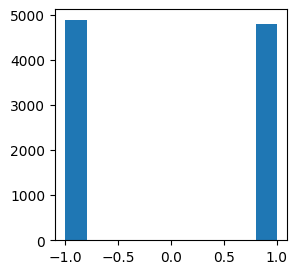

In [76]:
plt.hist(model_signs);

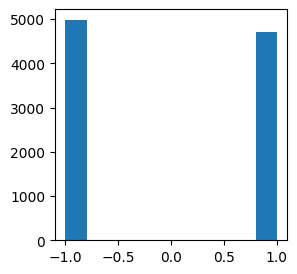

In [77]:
plt.hist(real_signs);

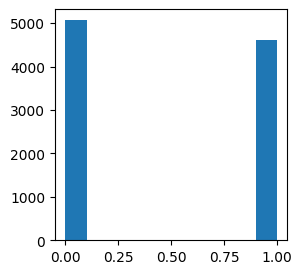

In [78]:
plt.hist(signs.astype(int));

In [31]:
target_means

array([-1.69848413e-10, -5.83741389e-12, -8.62621086e-12, -4.52737847e-11,
       -3.97523681e-11, -5.19757015e-11, -3.23524540e-11, -1.73454029e-11,
       -1.14054932e-10, -2.80856129e-05, -7.28885789e-05, -4.81990282e-05,
       -1.35375885e-05, -7.66285229e-05, -6.93737529e-05, -3.75141390e-05,
       -9.85842198e-05, -1.51721761e-05, -7.64653087e-05, -9.55909491e-05,
       -4.04249877e-05, -1.97440386e-07, -9.03159380e-05, -6.81467354e-05,
       -2.66544521e-05, -2.70903111e-05, -2.00271606e-05, -4.01586294e-05,
       -2.58982182e-05, -7.35521317e-05], dtype=float32)

In [34]:
np.sign(target_means) == np.sign(model_means)

array([ True, False,  True, False, False, False,  True,  True, False,
        True, False,  True,  True, False,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True])